# Air quality comparison in Turin during 2020
Comparing Google mobility data with air quality data provided by regional autority (ARPA).

In [9]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics

## Mobility Dataset:

### Reading mobility data 
Provided by: <br>
Google LLC "Google COVID-19 Community Mobility Reports".
https://www.google.com/covid19/mobility/ 

In [10]:
path = 'data/Mobility/2020_IT_Region_Mobility_Report.csv'
palette = ["blue","red","green","orange","purple","brown"]
labels=['Retail & Recreation','Grocery & Pharmacy','Parks','Transit stations','Workplaces','Residential']
positions = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']

it_mobility_data = pd.read_csv(path, parse_dates=['date'])

### Filtering Data

In [11]:
#Filtering by sub_region
to_mobility_data = it_mobility_data[it_mobility_data['sub_region_2'] == 'Metropolitan City of Turin'].copy()
#remove empty column
to_mobility_data.dropna(how='all', axis=1, inplace=True)

### Multi-Line plot

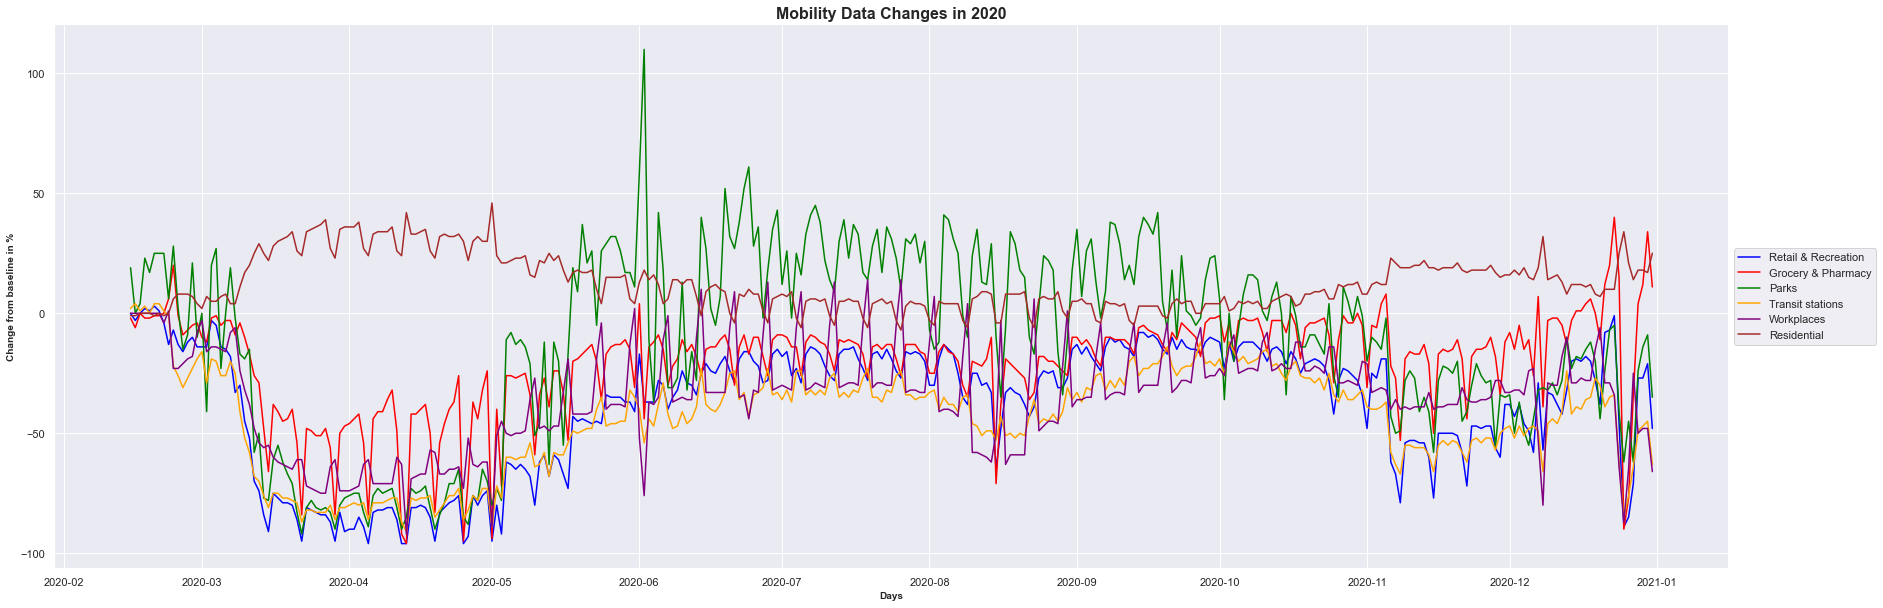

In [12]:
#set seaborn grapichs theme
sns.set_theme()

plt.figure(figsize=(30, 10))




# create a color palette
#palette = plt.get_cmap('Paired')

num = 0
plots =[]

for y in positions:
    line = to_mobility_data[y]
    p = plt.plot(to_mobility_data.date,line, label=labels[num], color=palette[num])
    plots += p
    num+=1

plt.xlabel('Days',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.ylabel('Change from baseline in %',fontdict= { 'fontsize': 10, 'fontweight':'bold'})
plt.legend(handles=plots)
plt.title("Mobility Data Changes in 2020",fontdict= { 'fontsize': 16, 'fontweight':'bold'})
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)
sns.despine()
plt.show()

## Air Quality Dataset:

### Reading ARPA data 
Provided by: <br>
Arpa Piemonte <br>
Dipartimento Rischi naturali e ambientali <br>
https://aria.ambiente.piemonte.it/

In [27]:
def read_ARPA_csv(path):
    dataFrame = pd.read_csv(path, sep=';',dtype={'Data rilevamento': str, 'Ora':str},index_col=False ) 

    #merge date and hours and parsing
    dataFrame["Data rilevamento"] = dataFrame["Data rilevamento"] + " " +  dataFrame["Ora"]
    dataFrame["Data rilevamento"] = pd.to_datetime(dataFrame["Data rilevamento"], format='%d/%m/%Y %H:%M') 
    return dataFrame

def get_daily_adjusted_data(path):
    initial_data=read_ARPA_csv(path)
    #group by day
    data_daily = initial_data.resample('D', on='Data rilevamento').mean()
    #adjusting on baseline
    reference_period = initial_data[(initial_data['Data rilevamento'] >= '2020-01-03') & (initial_data['Data rilevamento'] < '2020-02-06')]
    basevalue = reference_period['Valore'].mean()
    adjusted_data = data_daily[(data_daily.index.get_level_values('Data rilevamento') >= '2020-02-15')]
    adjusted_data -= basevalue
    return adjusted_data   

### Get Air Quality Data

#### PM10

In [29]:
consolata_pm10=get_daily_adjusted_data('data/ARPA/Torino-Consolata_Polveri-sottili_2020-01-01_2020-12-31.csv')
rebaudengo_pm10 = get_daily_adjusted_data('data/ARPA/Torino-Rebaudengo_Polveri-sottili_2020-01-01_2020-12-31.csv')
lingotto_pm10 = get_daily_adjusted_data('data/ARPA/Torino-Lingotto_Polveri-sottili_2020-01-01_2020-12-31.csv')
rubino_pm10 = get_daily_adjusted_data('data/ARPA/Torino-Rubino_Polveri-sottili_2020-01-01_2020-12-31.csv')
grassi_pm10 =get_daily_adjusted_data('data/ARPA/Torino-Grassi_Polveri-sottili_2020-01-01_2020-12-31.csv')
avg_turin_pm10=pd.concat([rebaudengo_pm10,consolata_pm10,lingotto_pm10,rubino_pm10,grassi_pm10]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_pm10 = avg_turin_pm10.rename(columns = {'Valore':'PM10'})

#### NOx

In [33]:
consolata_nox=get_daily_adjusted_data('data/ARPA/Torino-Consolata_Gas_2020-01-01_2020-12-31.csv')
rebaudengo_nox = get_daily_adjusted_data('data/ARPA/Torino-Rebaudengo_Gas_2020-01-01_2020-12-31.csv')
lingotto_nox = get_daily_adjusted_data('data/ARPA/Torino-Lingotto_Gas_2020-01-01_2020-12-31.csv')
# rubino_nox = get_daily_adjusted_data('data/ARPA/Torino-Rubino_Gas_2020-01-01_2020-12-31.csv')
# grassi_nox =get_daily_adjusted_data('data/ARPA/Torino-Grassi_Gas_2020-01-01_2020-12-31.csv')
avg_turin_nox=pd.concat([consolata_nox,rebaudengo_nox,lingotto_nox]).groupby('Data rilevamento', as_index=True).mean()
avg_turin_nox = avg_turin_nox.rename(columns = {'Valore':'NOx'})

### Merging both dataset

In [35]:
merged_data = to_mobility_data.merge(avg_turin_nox[['NOx']], left_on='date', right_on='Data rilevamento')
merged_data = merged_data.merge(avg_turin_pm10[['PM10']], left_on='date', right_on='Data rilevamento')

### Merged Lineplot

<AxesSubplot:>

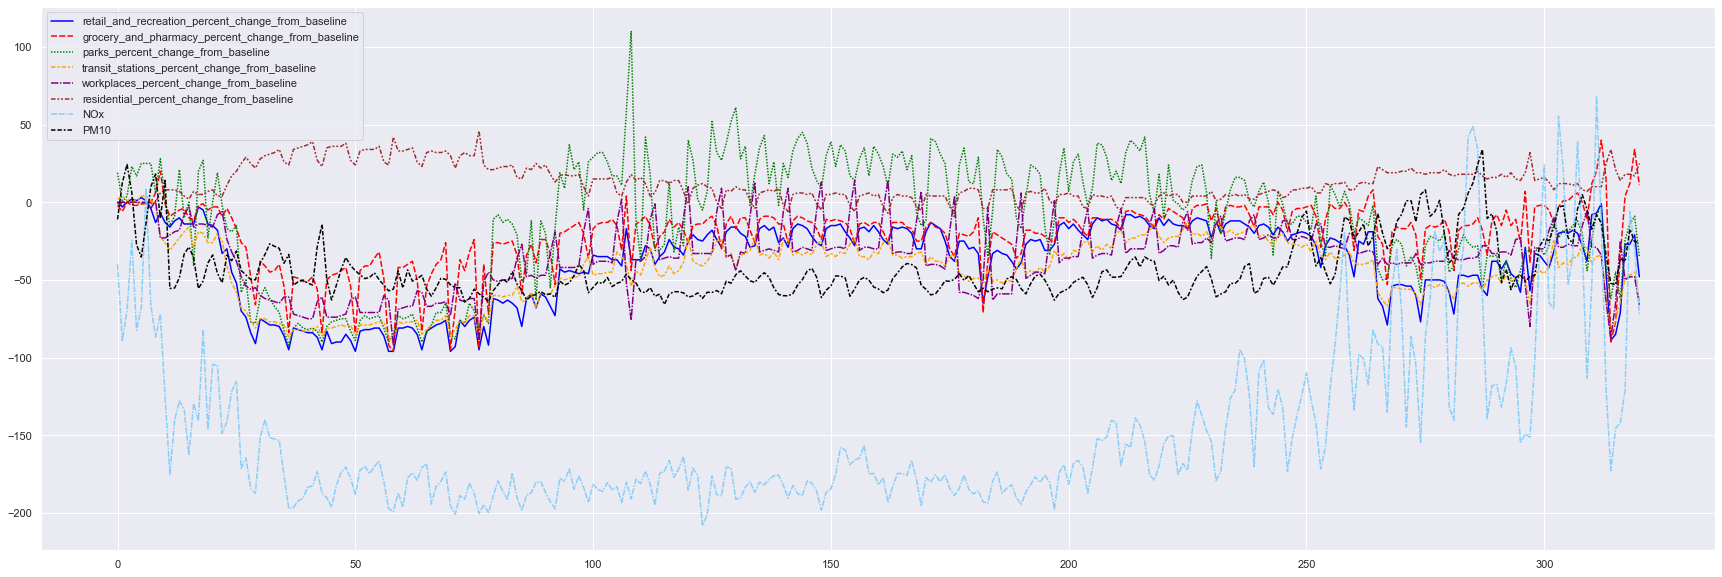

In [36]:
plt.figure(figsize=(30, 10))
palette = ["blue","red","green","orange","purple","brown","lightskyblue","black"]
sns.lineplot(data=merged_data, palette=palette)